In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install -q xplique keras_cv vit_keras
# !cp -r "/content/drive/MyDrive/Saliency Strike Back/data/vit_explanations" ./  # don't really need this actually...
!cp "/content/drive/MyDrive/Metrics Baseline/Data/results_vit" ./

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import xplique
from xplique.attributions import *
import tensorflow as tf
import numpy as np
import keras_cv
from keras_cv.models import *

from matplotlib import pyplot as plt
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'retina'

def set_size(w,h):
  """Set matplot figure size"""
  plt.rcParams["figure.figsize"] = [w,h]

def show(img, **kwargs):
  img = np.array(img)
  img -= img.min()
  img /= img.max()
  plt.imshow(img, **kwargs)
  plt.axis('off')

import seaborn as sns
sns.set(font_scale=2)

Using TensorFlow backend


<ipython-input-7-f6199f6b849b>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
# Load the results from the data folder to check what's inside
results_vit = np.load("results_vit", allow_pickle=True)
results_vit

array([['Saliency.npy', '0.7057913541793823', '0.7624197602272034'],
       ['vit_GuidedBackprop.npy', '0.7605510950088501',
        '0.7906367182731628'],
       ['SquareGrad.npy', '0.660179615020752', '0.8730495572090149'],
       ['vit_HsicAttributionMethod.npy', '0.719462513923645',
        '0.8590981364250183'],
       ['vit_DeconvNet.npy', '0.7522806525230408', '0.8136807680130005'],
       ['IntegratedGradients.npy', '0.8087055087089539',
        '0.7619964480400085'],
       ['vit_SobolAttributionMethod.npy', '0.730333149433136',
        '0.8479081988334656'],
       ['vit_Occlusion.npy', '0.7585330605506897', '0.7838580012321472'],
       ['GradientInput.npy', '0.756916344165802', '0.8375846743583679'],
       ['vit_Rise.npy', '0.7571014165878296', '0.8610683679580688'],
       ['VarGrad.npy', '0.6620939373970032', '0.8345974683761597'],
       ['SmoothGrad.npy', '0.6779276132583618', '0.843837559223175']],
      dtype='<U32')

In [ ]:
results_vit[0]

array(['Saliency.npy', '0.7057913541793823', '0.7624197602272034'],
      dtype='<U32')

In [ ]:
results_vit_str = [
    "zero Saliency.npy 0.7843191027641296 0.8422678709030151",
    "zero vit_GuidedBackprop.npy 0.8369522094726562 0.8501550555229187",
    "zero SquareGrad.npy 0.7033382654190063 0.8857612609863281",
    "zero vit_HsicAttributionMethod.npy 0.7487379312515259 0.8899978399276733",
    "zero vit_DeconvNet.npy 0.8369522094726562 0.8501550555229187",
    "zero IntegratedGradients.npy 0.8453978300094604 0.8463401794433594",
    "zero vit_SobolAttributionMethod.npy 0.7640781402587891 0.8853653073310852",
    "zero vit_Occlusion.npy 0.7794022560119629 0.8181172609329224",
    "zero GradientInput.npy 0.8451865315437317 0.8545977473258972",
    "zero vit_Rise.npy 0.7786698937416077 0.9092900156974792",
    "zero VarGrad.npy 0.7027909159660339 0.8829518556594849",
    "zero SmoothGrad.npy 0.7609480023384094 0.8940561413764954",
    "uniform Saliency.npy 0.7841745615005493 0.8210460543632507",
    "uniform vit_GuidedBackprop.npy 0.8029524683952332 0.8141887784004211",
    "uniform SquareGrad.npy 0.7222835421562195 0.8766821622848511",
    "uniform vit_HsicAttributionMethod.npy 0.7542874813079834 0.894749641418457",
    "uniform vit_DeconvNet.npy 0.7993431091308594 0.8160815238952637",
    "uniform IntegratedGradients.npy 0.8076492547988892 0.8129643201828003",
    "uniform vit_SobolAttributionMethod.npy 0.7704535126686096 0.8874664306640625",
    "uniform vit_Occlusion.npy 0.7762870788574219 0.8097747564315796",
    "uniform GradientInput.npy 0.8069064021110535 0.8257564306259155",
    "uniform vit_Rise.npy 0.7739336490631104 0.9048014879226685",
    "uniform VarGrad.npy 0.7183061838150024 0.8726837038993835",
    "uniform SmoothGrad.npy 0.725257933139801 0.8595024347305298",
    "normal Saliency.npy 0.770443320274353 0.8120197057723999",
    "normal vit_GuidedBackprop.npy 0.7870370149612427 0.8045791387557983",
    "normal SquareGrad.npy 0.7195155024528503 0.8720544576644897",
    "normal vit_HsicAttributionMethod.npy 0.7518832683563232 0.8934181928634644",
    "normal vit_DeconvNet.npy 0.7854738235473633 0.8045929074287415",
    "normal IntegratedGradients.npy 0.7874144315719604 0.7963245511054993",
    "normal vit_SobolAttributionMethod.npy 0.7645895481109619 0.8851345181465149",
    "normal vit_Occlusion.npy 0.7749677896499634 0.8084805607795715",
    "normal GradientInput.npy 0.789912760257721 0.8069164156913757",
    "normal vit_Rise.npy 0.7639247179031372 0.901057243347168",
    "normal VarGrad.npy 0.7130958437919617 0.8677716255187988",
    "normal SmoothGrad.npy 0.7040346264839172 0.8493248224258423",
    "permutation Saliency.npy 0.778896689414978 0.8361796140670776",
    "permutation vit_GuidedBackprop.npy 0.7931647896766663 0.8195459246635437",
    "permutation SquareGrad.npy 0.7313502430915833 0.8881028890609741",
    "permutation vit_HsicAttributionMethod.npy 0.7805873155593872 0.9054168462753296",
    "permutation vit_DeconvNet.npy 0.7919443249702454 0.8146048784255981",
    "permutation IntegratedGradients.npy 0.7943258285522461 0.8127380609512329",
    "permutation vit_SobolAttributionMethod.npy 0.7924537658691406 0.903302788734436",
    "permutation vit_Occlusion.npy 0.8014707565307617 0.8295995593070984",
    "permutation GradientInput.npy 0.7916368246078491 0.8207882642745972",
    "permutation vit_Rise.npy 0.7845590710639954 0.9103938937187195",
    "permutation VarGrad.npy 0.7291806936264038 0.8832523226737976",
    "permutation SmoothGrad.npy 0.7267570495605469 0.8585091829299927",
    "local_mean Saliency.npy 0.763739287853241 0.866730809211731",
    "local_mean vit_GuidedBackprop.npy 0.8005434274673462 0.8533895611763",
    "local_mean SquareGrad.npy 0.7173115611076355 0.9090428352355957",
    "local_mean vit_HsicAttributionMethod.npy 0.7463319897651672 0.9092773199081421",
    "local_mean vit_DeconvNet.npy 0.8005434274673462 0.8533895611763",
    "local_mean IntegratedGradients.npy 0.7942072749137878 0.8493987917900085",
    "local_mean vit_SobolAttributionMethod.npy 0.7636715769767761 0.9078114628791809",
    "local_mean vit_Occlusion.npy 0.7897824048995972 0.8344038128852844",
    "local_mean GradientInput.npy 0.7950574159622192 0.8566610217094421",
    "local_mean vit_Rise.npy 0.7742565274238586 0.911960780620575",
    "local_mean VarGrad.npy 0.7173238396644592 0.9076266288757324",
    "local_mean SmoothGrad.npy 0.7444561123847961 0.8889337778091431",
    "local_permutation Saliency.npy 0.6956838369369507 0.7898951768875122",
    "local_permutation vit_GuidedBackprop.npy 0.7285596132278442 0.7792301177978516",
    "local_permutation SquareGrad.npy 0.6654821634292603 0.851182758808136",
    "local_permutation vit_HsicAttributionMethod.npy 0.724478006362915 0.8823204040527344",
    "local_permutation vit_DeconvNet.npy 0.7289819717407227 0.7781441807746887",
    "local_permutation IntegratedGradients.npy 0.735893726348877 0.7738645672798157",
    "local_permutation vit_SobolAttributionMethod.npy 0.7373495697975159 0.879542350769043",
    "local_permutation vit_Occlusion.npy 0.7271907329559326 0.7699461579322815",
    "local_permutation GradientInput.npy 0.7293609380722046 0.7836347818374634",
    "local_permutation vit_Rise.npy 0.7458000183105469 0.8912827372550964",
    "local_permutation VarGrad.npy 0.6647666692733765 0.8563500642776489",
    "local_permutation SmoothGrad.npy 0.6658411622047424 0.8195298314094543",
    "mean Saliency.npy 0.8006118535995483 0.8628526926040649",
    "mean vit_GuidedBackprop.npy 0.8514920473098755 0.870947539806366",
    "mean SquareGrad.npy 0.7189014554023743 0.9010448455810547",
    "mean vit_HsicAttributionMethod.npy 0.7735669016838074 0.9059174656867981",
    "mean vit_DeconvNet.npy 0.8514920473098755 0.870947539806366",
    "mean IntegratedGradients.npy 0.8538482785224915 0.868384063243866",
    "mean vit_SobolAttributionMethod.npy 0.7820205688476562 0.9029378890991211",
    "mean vit_Occlusion.npy 0.8003398180007935 0.8383790254592896",
    "mean GradientInput.npy 0.8519771695137024 0.8766378164291382",
    "mean vit_Rise.npy 0.7979776263237 0.921595573425293",
    "mean VarGrad.npy 0.7198759913444519 0.8962736129760742",
    "mean SmoothGrad.npy 0.7870230674743652 0.909955620765686",
    "median Saliency.npy 0.7997954487800598 0.8655464053153992",
    "median vit_GuidedBackprop.npy 0.8488460779190063 0.8730071187019348",
    "median SquareGrad.npy 0.7211006283760071 0.9034442901611328",
    "median vit_HsicAttributionMethod.npy 0.7766278982162476 0.9079631567001343",
    "median vit_DeconvNet.npy 0.8488460779190063 0.8730071187019348",
    "median IntegratedGradients.npy 0.8498573303222656 0.8718913793563843",
    "median vit_SobolAttributionMethod.npy 0.7835975289344788 0.9039542078971863",
    "median vit_Occlusion.npy 0.7984403967857361 0.8404582738876343",
    "median GradientInput.npy 0.8490475416183472 0.8795116543769836",
    "median vit_Rise.npy 0.8017469644546509 0.9221512079238892",
    "median VarGrad.npy 0.7222906351089478 0.8977095484733582",
    "median SmoothGrad.npy 0.7926822304725647 0.907802939414978",
    "random_color Saliency.npy 0.7057913541793823 0.7624197602272034",
    "random_color vit_GuidedBackprop.npy 0.7605510950088501 0.7906367182731628",
    "random_color SquareGrad.npy 0.660179615020752 0.8730495572090149",
    "random_color vit_HsicAttributionMethod.npy 0.719462513923645 0.8590981364250183",
    "random_color vit_DeconvNet.npy 0.7522806525230408 0.8136807680130005",
    "random_color IntegratedGradients.npy 0.8087055087089539 0.7619964480400085",
    "random_color vit_SobolAttributionMethod.npy 0.730333149433136 0.8479081988334656",
    "random_color vit_Occlusion.npy 0.7585330605506897 0.7838580012321472",
    "random_color GradientInput.npy 0.756916344165802 0.8375846743583679",
    "random_color vit_Rise.npy 0.7571014165878296 0.8610683679580688",
    "random_color VarGrad.npy 0.6620939373970032 0.8345974683761597",
    "random_color SmoothGrad.npy 0.6779276132583618 0.843837559223175",
]

In [ ]:
results = {}
for r in results_vit_str:
  parts = r.split()
  if len(parts) != 4:
    continue  # Skip entries that do not conform to the expected format
  baseline_name, method_name, deletion, insertion = parts
  method_name = method_name[4:] if method_name[:4] == "vit_" else method_name
  method_name = method_name[:-4]
  try:
    # Convert strings to floats for numerical values
    deletion = float(deletion)
    insertion = float(insertion)
  except ValueError:
    continue  # Skip entries where conversion to float fails

  # Use (name, method_name) as the key and (first_value, second_value) as the value
  key = (baseline_name, method_name)
  value = (deletion, insertion)
  results[key] = value
results

{('zero', 'Saliency'): (0.7843191027641296, 0.8422678709030151),
 ('zero', 'GuidedBackprop'): (0.8369522094726562, 0.8501550555229187),
 ('zero', 'SquareGrad'): (0.7033382654190063, 0.8857612609863281),
 ('zero', 'HsicAttributionMethod'): (0.7487379312515259, 0.8899978399276733),
 ('zero', 'DeconvNet'): (0.8369522094726562, 0.8501550555229187),
 ('zero', 'IntegratedGradients'): (0.8453978300094604, 0.8463401794433594),
 ('zero', 'SobolAttributionMethod'): (0.7640781402587891, 0.8853653073310852),
 ('zero', 'Occlusion'): (0.7794022560119629, 0.8181172609329224),
 ('zero', 'GradientInput'): (0.8451865315437317, 0.8545977473258972),
 ('zero', 'Rise'): (0.7786698937416077, 0.9092900156974792),
 ('zero', 'VarGrad'): (0.7027909159660339, 0.8829518556594849),
 ('zero', 'SmoothGrad'): (0.7609480023384094, 0.8940561413764954),
 ('uniform', 'Saliency'): (0.7841745615005493, 0.8210460543632507),
 ('uniform', 'GuidedBackprop'): (0.8029524683952332, 0.8141887784004211),
 ('uniform', 'SquareGrad'): 

In [ ]:
from typing import Dict, Tuple
import pandas as pd

In [ ]:
def plot_method_rankings_by_rank(data: Dict[Tuple[str, str], Tuple[float, float]]):
    """
    Generates two plots to visualize the rankings of methods based purely on their rank positions
    for two separate values. Each plot corresponds to one of the values, showing how different methods
    rank across various names based on ranking rather than actual value.

    Args:
    data (Dict[Tuple[str, str], Tuple[float, float]]): Dictionary with keys as tuples of (name, method name)
                                                       and values as tuples of (first value, second value).
    """
    # Convert dictionary to DataFrame for easier manipulation
    df = pd.DataFrame({
        'Baseline': [k[0] for k in data.keys()],
        'Method': [k[1] for k in data.keys()],
        'Deletion': [v[0] for v in data.values()],
        'Insertion': [v[1] for v in data.values()]
    })

    # Calculate rankings within each 'Name' group
    df['Rank Deletion'] = df.groupby('Baseline')['Deletion'].rank(method='min', ascending=False)
    df['Rank Insertion'] = df.groupby('Baseline')['Insertion'].rank(method='min', ascending=False)

    # Setting up the matplotlib figure
    plt.figure(figsize=(14, 6))

   # Plotting Rank for Value 1
    plt.subplot(1, 2, 1)
    sns.lineplot(x='Baseline', y='Rank Deletion', hue='Method', data=df, marker='o', linestyle='-', palette='viridis')
    plt.title('Ranking of Methods by Deletion')
    plt.xlabel('Baseline')
    plt.ylabel('Rank for Deletion')
    plt.legend([],[], frameon=False)
    # plt.legend(title='Method')
    plt.gca().invert_yaxis()  # Higher ranks (lower numbers) should appear higher on the plot

    # Plotting Rank for Value 2
    plt.subplot(1, 2, 2)
    sns.lineplot(x='Baseline', y='Rank Insertion', hue='Method', data=df, marker='o', linestyle='-', palette='cividis')
    plt.title('Ranking of Methods by Insertion')
    plt.xlabel('Baseline')
    plt.ylabel('Rank for Insertion')
    # plt.legend(title='Method')
    plt.legend([],[], frameon=False)
    plt.gca().invert_yaxis()  # Higher ranks (lower numbers) should appear higher on the plot


    # Display the plots
    plt.tight_layout()
    plt.show()

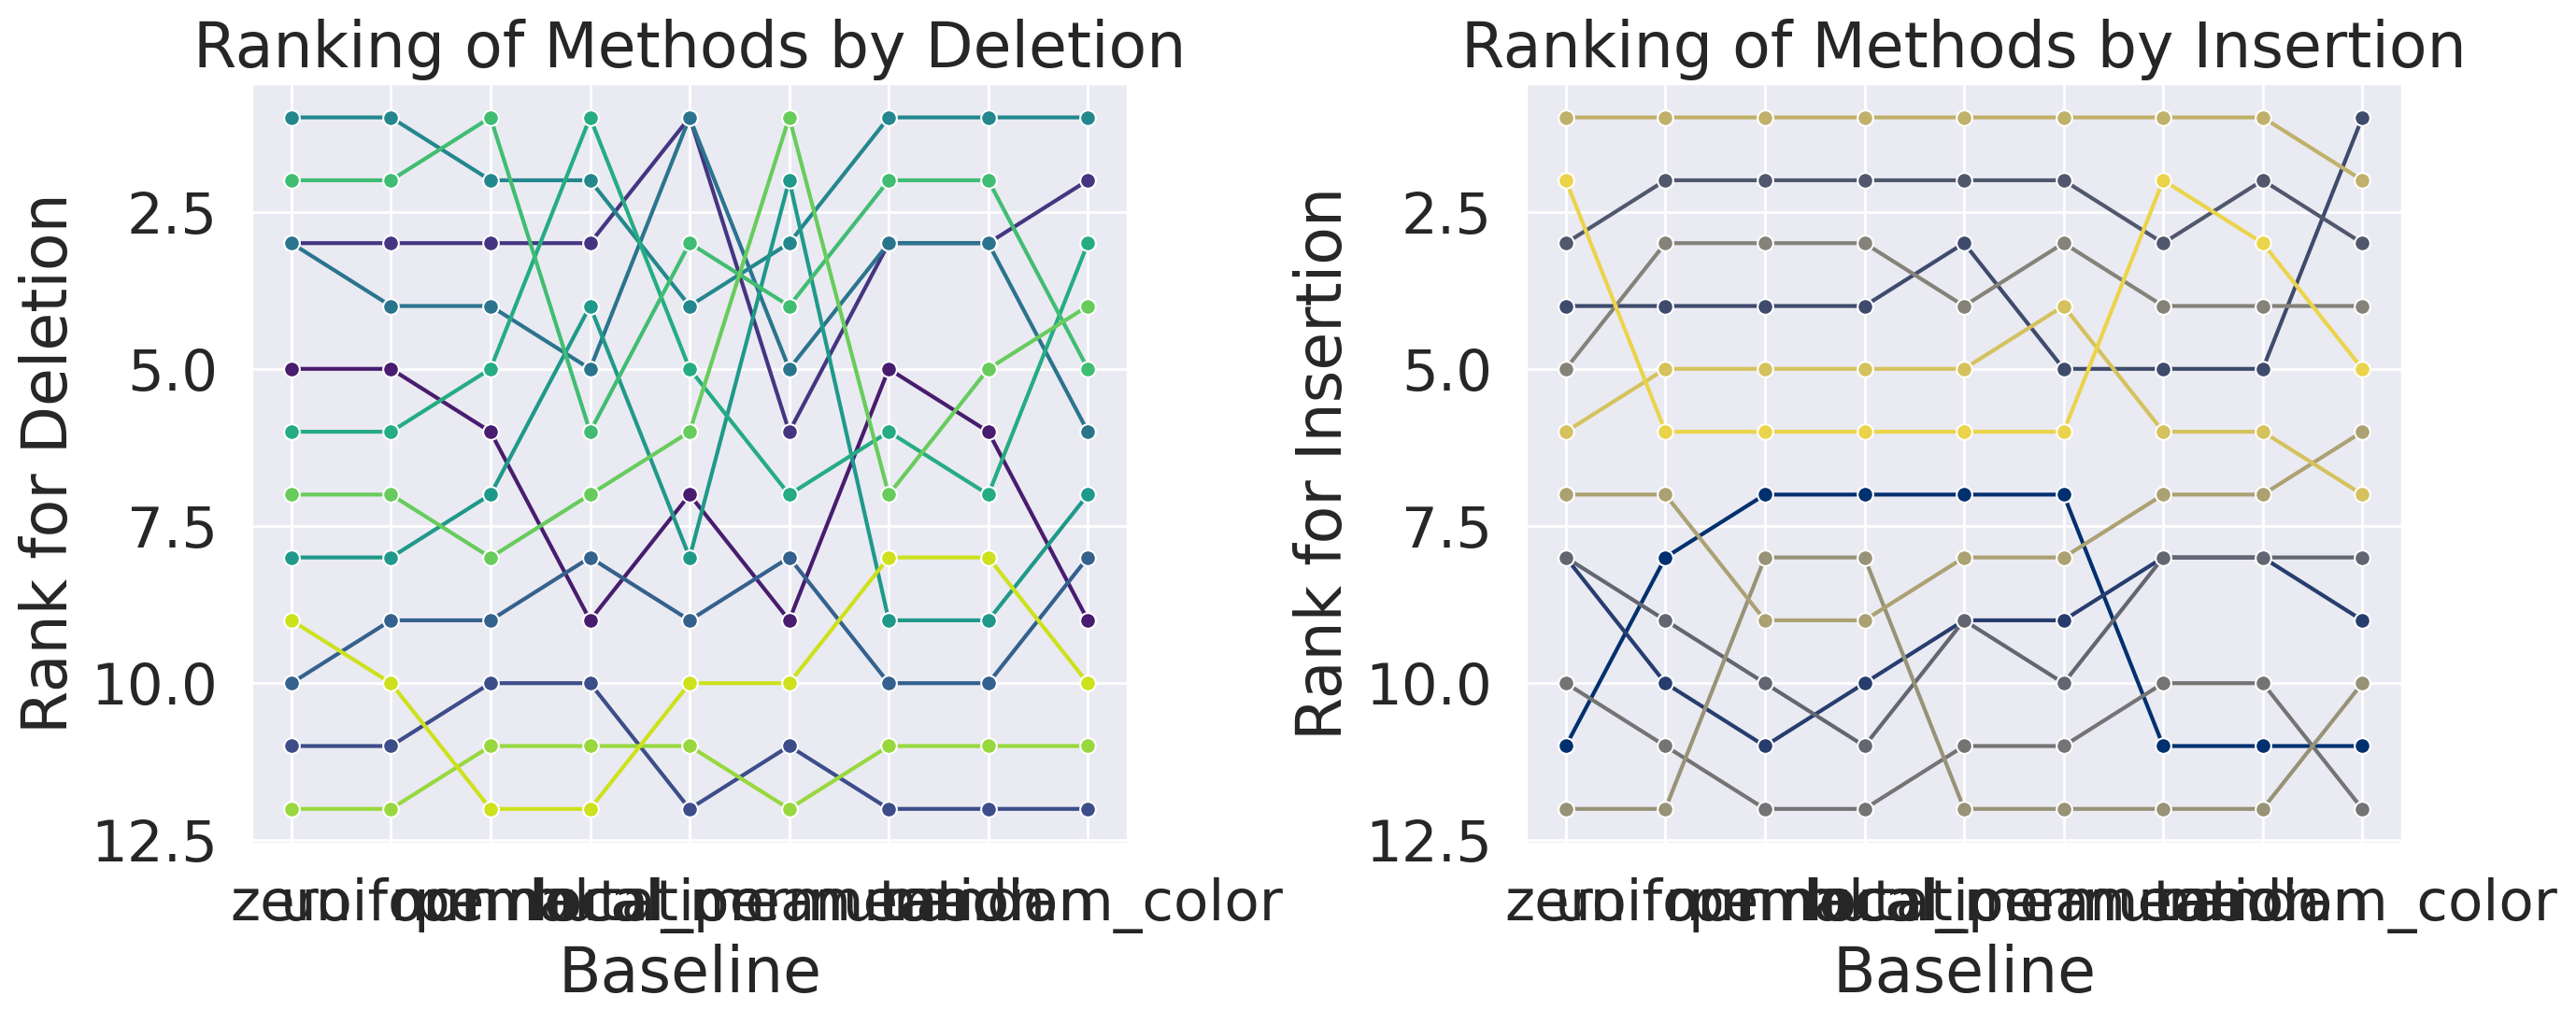

In [ ]:
plot_method_rankings_by_rank(results)

## Better plot to actually add it to the paper

In [60]:
def set_size_custom(width, height):
    """ Helper function to set the size of the plot """
    plt.gcf().set_size_inches(width, height)

def plot_method_rankings_custom(data: Dict[Tuple[str, str], Tuple[float, float]]):
    """
    Generates line plots to visualize the rankings of methods based on their positions for two
    separate metrics (similar to 'deletion' and 'insertion' ranks), styled similarly to the given code.

    Args:
    data (Dict[Tuple[str, str], Tuple[float, float]]): Dictionary with keys as tuples of (name, method name)
                                                       and values as tuples of (first value, second value).
    """
    # Convert dictionary to DataFrame for easier manipulation
    df = pd.DataFrame({
        'Name': [k[0] for k in data.keys()],
        'Method': [k[1] for k in data.keys()],
        'Value 1': [v[0] for v in data.values()],
        'Value 2': [v[1] for v in data.values()]
    })

    # Prepare ranks based on values
    df['Rank Value 1'] = df.groupby('Name')['Value 1'].rank(method='min', ascending=True)
    df['Rank Value 2'] = df.groupby('Name')['Value 2'].rank(method='min', ascending=False)

    methods = sorted(set(df['Method']))
    baselines = sorted(set(df['Name']))

    sns.set(font_scale=1.4)
    set_size_custom(13, 10)
    cmap = plt.get_cmap('viridis_r')

    # Plotting for Value 1 (like 'deletion')
    lw = 3.0
    plt.figure(figsize=(13, 10))
    for m in methods:
        order = [len(methods) - df[(df['Name'] == b) & (df['Method'] == m)]['Rank Value 1'].values[0] for b in baselines]
        color = cmap((len(methods) - np.mean(order)) / len(methods))
        plt.plot(order, label=m, c=color, linewidth=lw)

    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.45), fancybox=True, shadow=True, borderpad=0.5, ncol=4, frameon=True, facecolor='white')
    plt.xticks(range(len(baselines)), baselines, rotation=45)
    # plt.yticks(range(1, len(methods) + 1))
    plt.yticks([0, len(methods)], [len(methods), 1])
    plt.ylabel('Rank')
    plt.title("Deletion Ranking")
    plt.tight_layout()
    plt.show()

    # Plotting for Value 2 (like 'insertion')
    plt.figure(figsize=(13, 10))
    for m in methods:
        order = [len(methods) - df[(df['Name'] == b) & (df['Method'] == m)]['Rank Value 2'].values[0] for b in baselines]
        color = cmap((len(methods) - np.mean(order)) / len(methods))
        plt.plot(order, label=m, c=color, linewidth=lw)

    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.45), fancybox=True, shadow=True, borderpad=0.5, ncol=4, frameon=True, facecolor='white')
    plt.xticks(range(len(baselines)), baselines, rotation=45)
    # plt.yticks(range(1, len(methods) + 1))
    plt.yticks([0, len(methods)], [len(methods), 1])
    plt.ylabel('Rank')
    plt.title("Insertion ranking")
    plt.tight_layout()
    plt.show()

<Figure size 1300x1000 with 0 Axes>

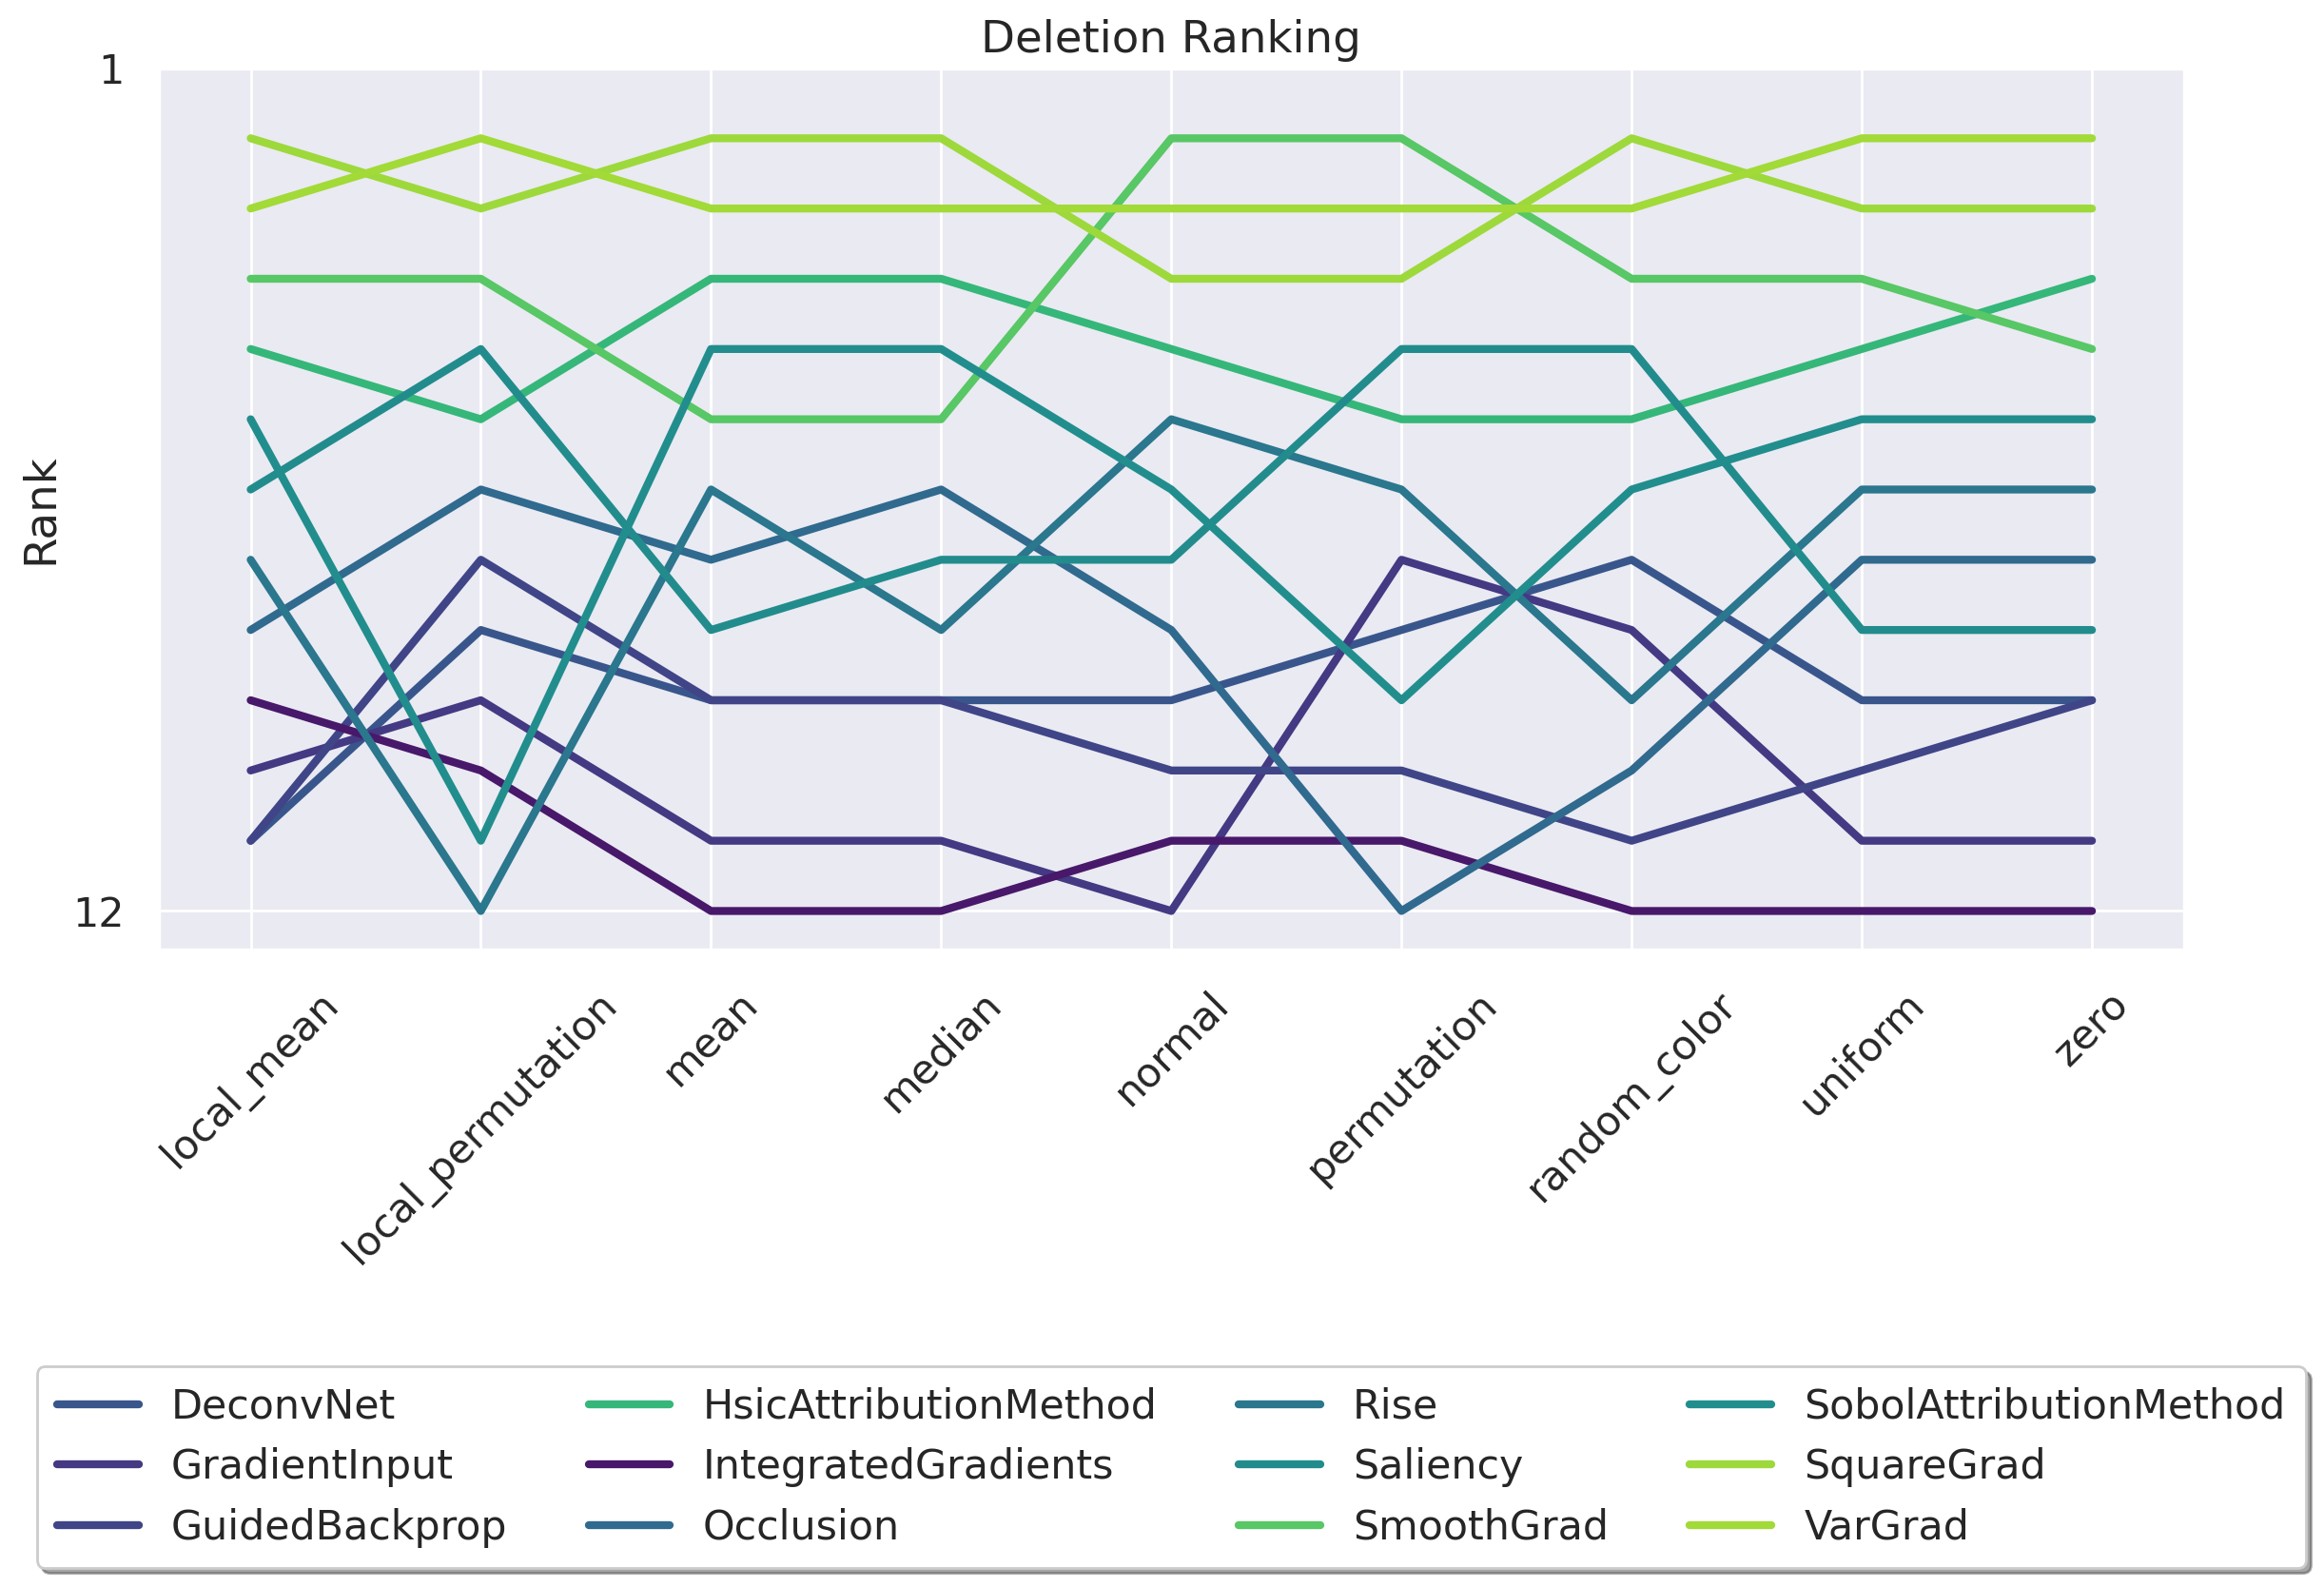

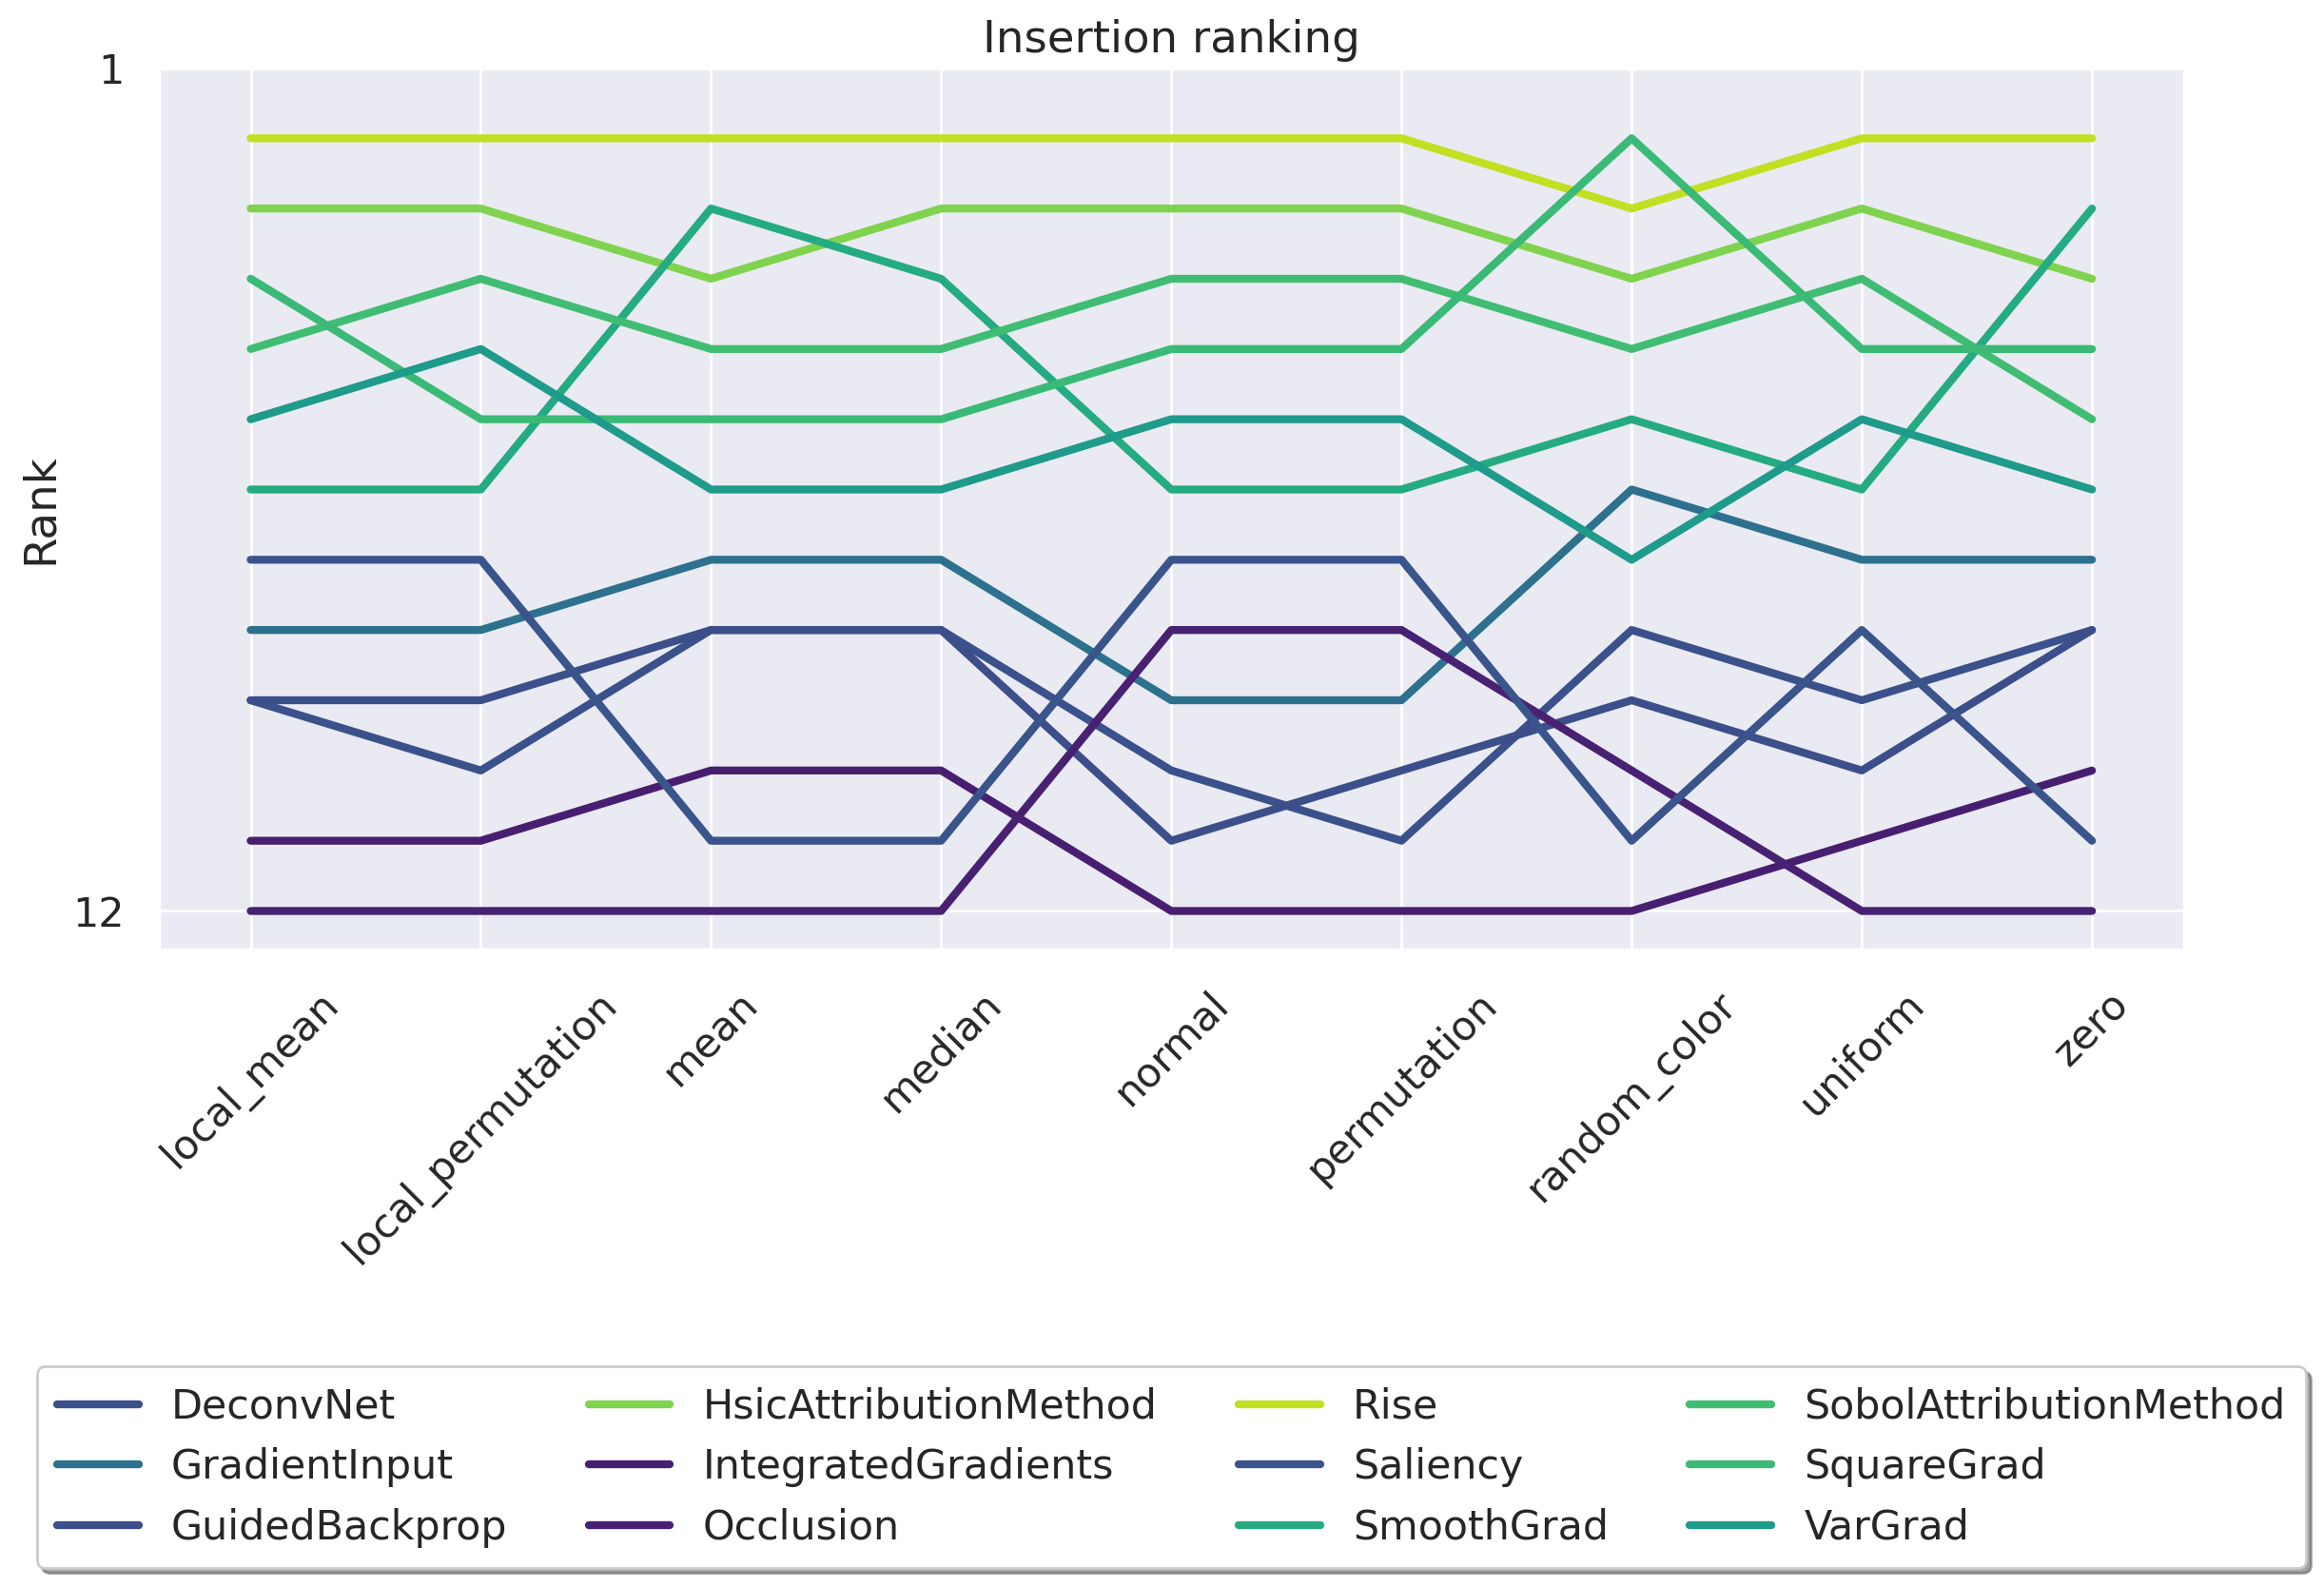

In [61]:
plot_method_rankings_custom(results)

## Amount of explanations per model

In [51]:
import os

In [ ]:
!cp -r "/content/drive/MyDrive/Saliency Strike Back/data/vit_explanations" ./
!cp -r "/content/drive/MyDrive/Saliency Strike Back/data/resnet50_explanations" ./

In [53]:
explanations_resnet50_dir = "./resnet50_explanations"
explanations_vit_dir = "./vit_explanations"
explanation_resnet50_files = [os.path.join(explanations_resnet50_dir, f) for f in os.listdir(explanations_resnet50_dir)]
explanation_vit_files = [os.path.join(explanations_vit_dir, f) for f in os.listdir(explanations_vit_dir)]

In [54]:
n_exp_r50 = 0
for f in explanation_resnet50_files:
  r = np.load(f)
  n_exp_r50 += r.shape[0]
n_exp_r50

14000

In [55]:
n_exp_vit = 0
for f in explanation_vit_files:
  r = np.load(f)
  n_exp_vit += r.shape[0]
n_exp_vit

6000